<a href="https://colab.research.google.com/github/Jalapinho1/Reinforcement-Learning-Agent_Frozen-Lake/blob/main/RL_Frozen_Lake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-Entropy Method Performance Analysis

In [7]:
import numpy as np
import torch
import torch.nn as nn
import gym
import gym.spaces

**Load** **the** **environment**

In [8]:
env = gym.make('FrozenLake-v0', is_slippery=False)

**Add onehot encoding**


In [9]:
class OneHotWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(OneHotWrapper, self).__init__(env)
        self.observation_space = gym.spaces.Box(0.0, 1.0, (env.observation_space.n, ), dtype=np.float32)

    def observation(self, observation):
        r = np.copy(self.observation_space.low)
        r[observation] = 1.0
        return r

env = OneHotWrapper(env)

**Agent based on a neural network**

The model, optimizer and loss function


In [28]:
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n
HIDDEN_SIZE = 32
net= nn.Sequential(
     nn.Linear(obs_size, HIDDEN_SIZE),
     nn.Sigmoid(),
     nn.Linear(HIDDEN_SIZE, n_actions)
)

objective = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)


**Get an Action**

In [11]:
sm = nn.Softmax(dim=1)
def select_action(state):
  state_t = torch.FloatTensor([state])
  act_probs_t = sm(net(state_t))
  act_probs = act_probs_t.data.numpy()[0]
  action = np.random.choice(len(act_probs), p=act_probs)
  return action

**Training the Agent**

The code begins by defining the main parameters of the method and defining helper classes


In [30]:
#main parameters
BATCH_SIZE = 100
GAMMA = 0.9
PERCENTILE = 30
REWARD_GOAL = 0.8

from collections import namedtuple

# helper classes
Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])

In [31]:
# init variables
iter_no = 0
reward_mean = 0
full_batch = []
batch = []            # accumulates the list of Episode instances
episode_steps = []    # accumulates the list of steps in the current episode
episode_reward = 0.0  # reward counter for the current episode
                      # (in our case, we only have a reward at the end of an episode)
state = env.reset()

In [32]:
# The training loop
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

# STEP 1
# We train the Agent until a certain Reward threshold is reached
while reward_mean < REWARD_GOAL:
        action = select_action(state)
        next_state, reward, episode_is_done, _ = env.step(action)
        
        # Important note - we save the observed state that was used to choose the action
        episode_steps.append(EpisodeStep(observation=state, action=action))
        episode_reward += reward
        
        #If the episoded is done-> add the Episode (which consists of EpisodeStates) into a batch    

        if episode_is_done: # Episode finished            
            batch.append(Episode(reward=episode_reward, steps=episode_steps))
            next_state = env.reset()
            episode_steps = []
            episode_reward = 0.0
             
            # STEP 2 - Calculate the Return for every episode and decide on a return boundary
            # If the number of episodes (len of batch) is equal to the constant -> we proceed
            if len(batch) == BATCH_SIZE: # New set of batches ready --> select "elite"
                # Reward_mean is used for finishing the training loop
                reward_mean = float(np.mean(list(map(lambda s: s.reward, batch))))
                elite_candidates= batch 
                # calculation of the final reward for all episodes
                # reward = initial reward * (GAMMA constant ^ number of steps in the episode)
                returnG = list(map(lambda s: s.reward * (GAMMA ** len(s.steps)), elite_candidates))
                reward_bound = np.percentile(returnG, PERCENTILE)

                # STEP 3 - Throw away all episodes with a return below the boundary
                train_obs = []
                train_act = []
                elite_batch = []
                # for every episode in the batch,
                # we will check that the episode has a higher total reward than our boundary
                for example, discounted_reward in zip(elite_candidates, returnG):
                        if discounted_reward > reward_bound:
                              # populate the list of observed states and actions that we will train on
                              train_obs.extend(map(lambda step: step.observation, example.steps))
                              train_act.extend(map(lambda step: step.action, example.steps))
                              elite_batch.append(example)
                # update the variables with the elite episodes, the list of states and actions with
                # which we will train out neural network
                full_batch=elite_batch
                state=train_obs
                acts=train_act

                # STEP 4 - Train the neural network using episode steps from the “elite” episodes
                if len(full_batch) != 0 : # just in case empty during an iteration
                 # transform the variables to tensors
                 state_t = torch.FloatTensor(state)
                 acts_t = torch.LongTensor(acts)
                 # we zero gradients of our neural network
                 optimizer.zero_grad()
                 # pass the observed state to the neural network, obtaining its action scores
                 action_scores_t = net(state_t)
                 # objective function, which will calculate cross-entropy between the - 
                 #   - neural network output and the actions that the agent took
                 loss_t = objective(action_scores_t, acts_t)
                 # we need to calculate gradients on the loss using the backward method
                 #   - and adjust the parameters of our neural network using the step method of the optimizer
                 loss_t.backward()
                 optimizer.step()

                 writer.add_scalar("loss", loss_t.item(), iter_no)
                 writer.add_scalar("reward_mean", reward_mean, iter_no)
                 print("%d: loss=%.3f, reward_mean=%.3f" % (iter_no, loss_t.item(), reward_mean))
                 iter_no += 1
                batch = []
        state = next_state

writer.close()

0: loss=1.454, reward_mean=0.010
1: loss=1.454, reward_mean=0.010
2: loss=1.414, reward_mean=0.020
3: loss=1.363, reward_mean=0.010
4: loss=1.386, reward_mean=0.020
5: loss=1.462, reward_mean=0.020
6: loss=1.354, reward_mean=0.010
7: loss=1.370, reward_mean=0.010
8: loss=1.348, reward_mean=0.010
9: loss=1.365, reward_mean=0.030
10: loss=1.387, reward_mean=0.010
11: loss=1.384, reward_mean=0.010
12: loss=1.376, reward_mean=0.010
13: loss=1.372, reward_mean=0.010
14: loss=1.362, reward_mean=0.020
15: loss=1.372, reward_mean=0.030
16: loss=1.389, reward_mean=0.040
17: loss=1.369, reward_mean=0.010
18: loss=1.379, reward_mean=0.010
19: loss=1.326, reward_mean=0.020
20: loss=1.307, reward_mean=0.030
21: loss=1.334, reward_mean=0.020
22: loss=1.333, reward_mean=0.050
23: loss=1.316, reward_mean=0.060
24: loss=1.227, reward_mean=0.010
25: loss=1.305, reward_mean=0.050
26: loss=1.319, reward_mean=0.030
27: loss=1.378, reward_mean=0.020
28: loss=1.244, reward_mean=0.030
29: loss=1.280, reward_m

In [33]:
test_env = OneHotWrapper(gym.make('FrozenLake-v0', is_slippery=False))
state= test_env.reset()
test_env.render()

is_done = False

while not is_done:
    action = select_action(state)
    new_state, reward, is_done, _ = test_env.step(action)
    test_env.render()
    state = new_state

print("reward = ", reward)


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
reward =  1.0


In [34]:
%load_ext tensorboard

In [ ]:
tensorboard --logdir=runs

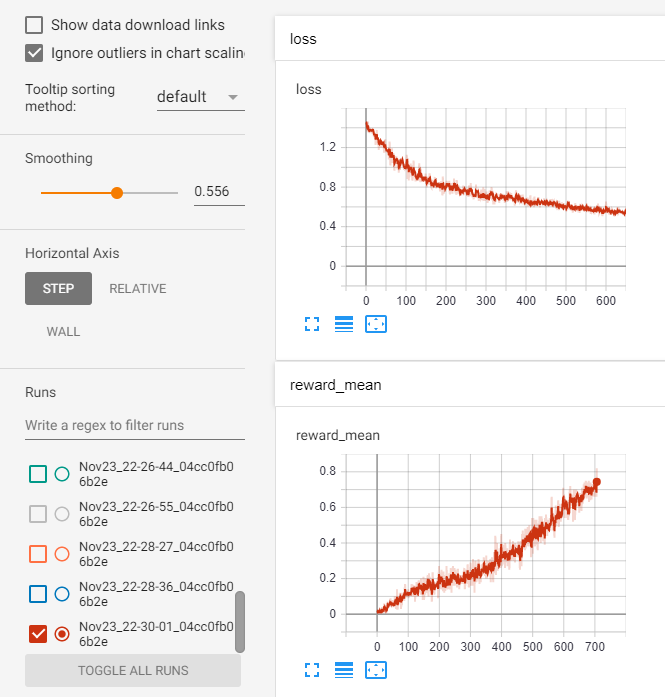



**More complex NN**

We can see that this network learns faster than the previous one.



In [37]:
HIDDEN_SIZE = 128
net= nn.Sequential(
           nn.Linear(obs_size, HIDDEN_SIZE),
           nn.Sigmoid(),
           nn.Linear(HIDDEN_SIZE, n_actions)
           )
objective = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
train_loop()

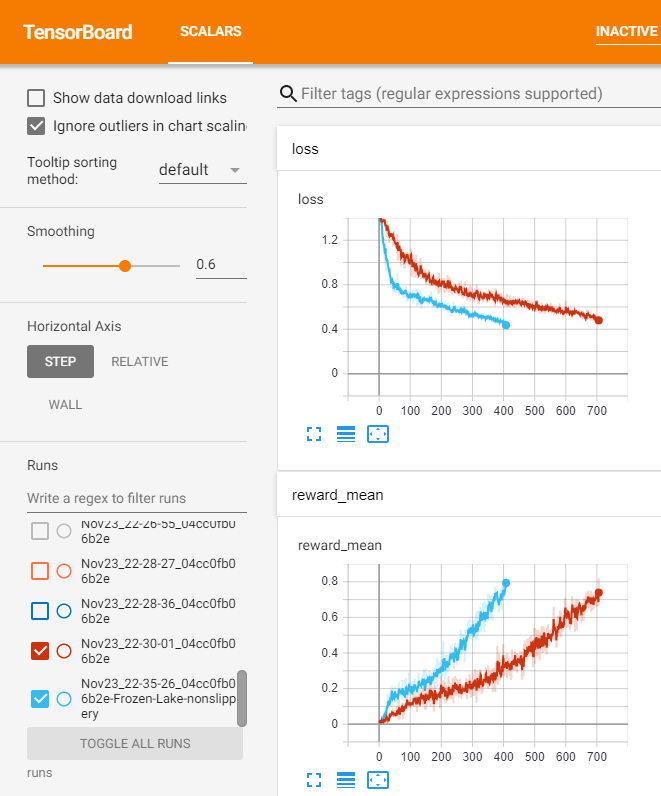

**Relu activation function**

Network converges much earlier

In [41]:
HIDDEN_SIZE = 128
net= nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, n_actions)
        )
objective = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

train_loop()

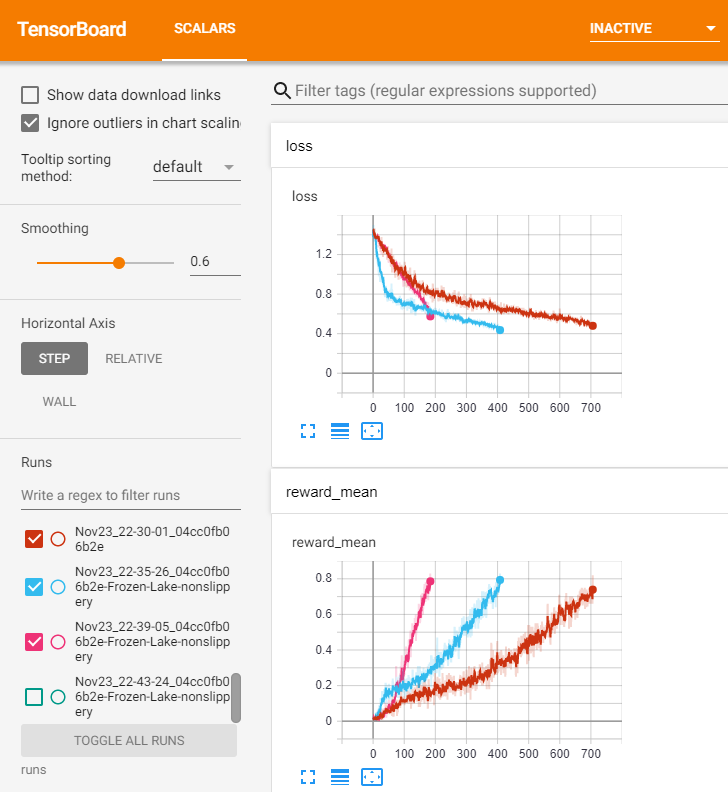

**Improving the Cross-Entropy algorithm**

We can keep “elite” episodes for a longer time. The previous version of the algorithm samples episodes from the Environment, train on the best ones and threw them away. However, when the number of successful episodes is small, the “elite” episodes can be maintained longer, keeping them for several iterations to train on them.

In [45]:
HIDDEN_SIZE = 128
net= nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, n_actions)
        )
objective = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

improved_train_loop()

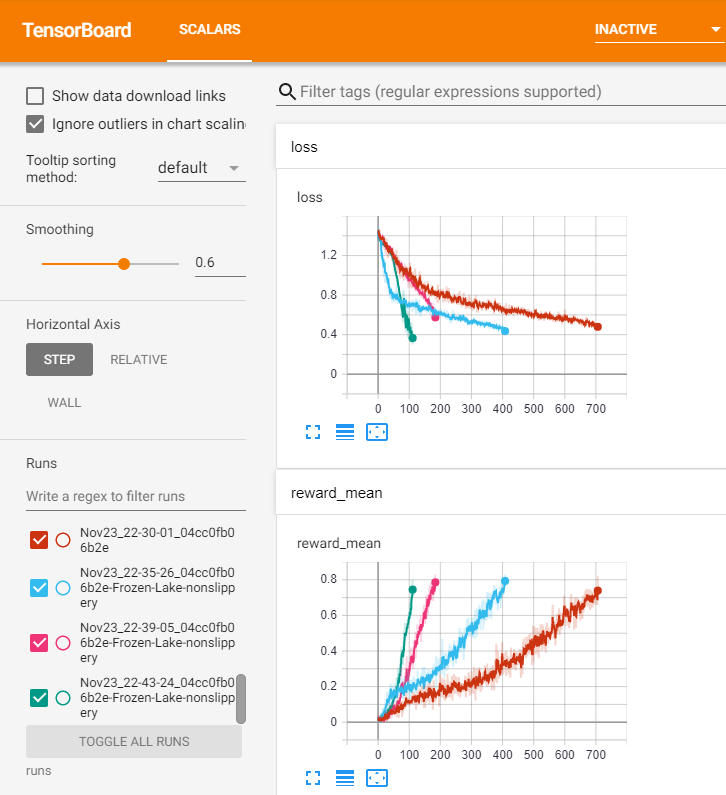

**Limitation of the Cross-Entropy method**

So far we have seen that with the proposed improvements, with very few iterations of the training loop we can find a good neural network. But this is because we are talking about a very simple “non-slippery” Environment



In [49]:
slippedy_env = gym.make('FrozenLake-v0', is_slippery=True)
class OneHotWrapper(gym.ObservationWrapper):
      def __init__(self, env):
          super(OneHotWrapper, self).__init__(env)
          self.observation_space = gym.spaces.Box(0.0, 1.0,
                (env.observation_space.n, ), dtype=np.float32)
 
      def observation(self, observation):
          r = np.copy(self.observation_space.low)
          r[observation] = 1.0
          return r
env = OneHotWrapper(slippedy_env)

In [ ]:
HIDDEN_SIZE = 128
net= nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, n_actions)
        )
objective = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

improved_train_loop()

In the following figure, we see the behavior of the algorithm during the first iterations. It is not able to take off the value of the Reward

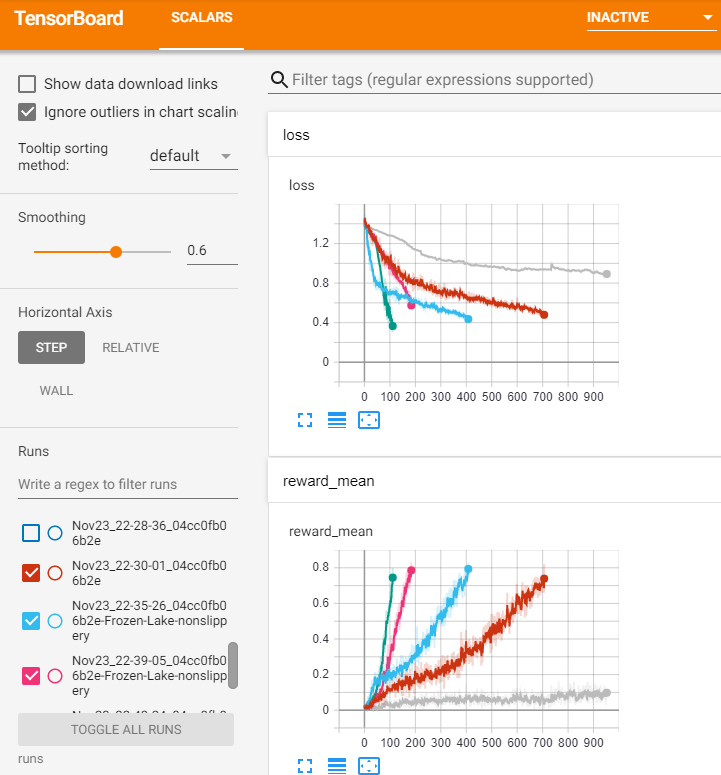

In [43]:
def improved_train_loop():
   writer = SummaryWriter(comment="-Frozen-Lake-nonslippery")

   iter_no = 0
   reward_mean = 0
   full_batch = []
   batch = []
   episode_steps = []
   episode_reward = 0.0
   state = env.reset()
    
   while reward_mean < REWARD_GOAL:
        action = select_action(state)
        next_state, reward, episode_is_done, _ = env.step(action)

        episode_steps.append(EpisodeStep(observation=state, action=action))
        episode_reward += reward
        
        if episode_is_done: # Episode finished            
            batch.append(Episode(reward=episode_reward, steps=episode_steps))
            next_state = env.reset()
            episode_steps = []
            episode_reward = 0.0
             
            if len(batch) == BATCH_SIZE: # New set of batches ready --> select "elite"
                reward_mean = float(np.mean(list(map(lambda s: s.reward, batch))))

                elite_candidates= full_batch + batch 
                #elite_candidates= batch 

                returnG = list(map(lambda s: s.reward * (GAMMA ** len(s.steps)), elite_candidates))
                reward_bound = np.percentile(returnG, PERCENTILE)

                train_obs = []
                train_act = []
                elite_batch = []
                for example, discounted_reward in zip(elite_candidates, returnG):
                        if discounted_reward > reward_bound:
                              train_obs.extend(map(lambda step: step.observation, example.steps))
                              train_act.extend(map(lambda step: step.action, example.steps))
                              elite_batch.append(example)
                full_batch=elite_batch
                state=train_obs
                acts=train_act

                
                if len(full_batch) != 0 : # just in case empty during an iteration
                       state_t = torch.FloatTensor(state)
                       acts_t = torch.LongTensor(acts)

                       optimizer.zero_grad()
                       action_scores_t = net(state_t)
                       loss_t = objective(action_scores_t, acts_t)
                       loss_t.backward()
                       optimizer.step()
                       writer.add_scalar("loss", loss_t.item(), iter_no)
                       writer.add_scalar("reward_mean", reward_mean, iter_no)
                       iter_no += 1
                batch = []
        state = next_state

   writer.close()

In [39]:
from torch.utils.tensorboard import SummaryWriter

def train_loop():
   writer = SummaryWriter(comment="-Frozen-Lake-nonslippery")

   iter_no = 0
   reward_mean = 0
   full_batch = []
   batch = []
   episode_steps = []
   episode_reward = 0.0
   state = env.reset()
    
   while reward_mean < REWARD_GOAL:
        action = select_action(state)
        next_state, reward, episode_is_done, _ = env.step(action)

        episode_steps.append(EpisodeStep(observation=state, action=action))
        episode_reward += reward
        
        if episode_is_done: # Episode finished            
            batch.append(Episode(reward=episode_reward, steps=episode_steps))
            next_state = env.reset()
            episode_steps = []
            episode_reward = 0.0
             
            if len(batch) == BATCH_SIZE: # New set of batches ready --> select "elite"
                reward_mean = float(np.mean(list(map(lambda s: s.reward, batch))))
                #elite_candidates= full_batch + batch 
                elite_candidates= batch 
                returnG = list(map(lambda s: s.reward * (GAMMA ** len(s.steps)), elite_candidates))
                reward_bound = np.percentile(returnG, PERCENTILE)

                train_obs = []
                train_act = []
                elite_batch = []
                for example, discounted_reward in zip(elite_candidates, returnG):
                        if discounted_reward > reward_bound:
                              train_obs.extend(map(lambda step: step.observation, example.steps))
                              train_act.extend(map(lambda step: step.action, example.steps))
                              elite_batch.append(example)
                full_batch=elite_batch
                state=train_obs
                acts=train_act

                
                if len(full_batch) != 0 : # just in case empty during an iteration
                       state_t = torch.FloatTensor(state)
                       acts_t = torch.LongTensor(acts)

                       optimizer.zero_grad()
                       action_scores_t = net(state_t)
                       loss_t = objective(action_scores_t, acts_t)
                       loss_t.backward()
                       optimizer.step()
                       writer.add_scalar("loss", loss_t.item(), iter_no)
                       writer.add_scalar("reward_mean", reward_mean, iter_no)
                       iter_no += 1
                batch = []
        state = next_state

   writer.close()